# Gender Classification using ResNet9 CNN (Convolutional Neural Network)


In this notebook, we will be working on a gender classification dataset from kaggle which contains 47009 images of males and females in the training set and 11649 images in Validation set.

We will use state of the art ResNet9 CNN model and train it upto `98%` test set accuracy.

The code cells are based on several different sections of the overall project.

The notebook covers:

- Picking and downloading a dataset from kaggle
- Accessing the Validation and Training Data in our notebook and applying transforms
- Exploring dataset examples
- Creating data loaders and moving them to default device
- Defining the Image Classification base class and extending it to ResNet9 model
- Definition of training and evaluation utility functions
- Training our model
- Evaluating model on single images from test set and on custom imported images
- Conclusion

## Picking and downloading a dataset from kaggle
Using the opendatasets library to download the gender classification dataset from kaggle

In [ ]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [ ]:
dataset_url = 'https://www.kaggle.com/cashutosh/gender-classification-dataset'
od.download(dataset_url)

100%|██████████| 269M/269M [00:02<00:00, 139MB/s]


Importing some of the libraries we will be using

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from torchvision.datasets import ImageFolder

## Accessing the Validation and Training Data in our notebook and applying transforms

Checking the folders in the dataset downloaded datset

In [ ]:
data_dir = './gender-classification-dataset'
os.listdir(data_dir)

['Training', 'Validation']

So we have two folders:
1. Training
2. Validation

Both contain two classes:
1. Male
2. Female

In [ ]:
classes = os.listdir(data_dir + '/Training')
classes

['female', 'male']

Lets check the number of images for male and female folder inside Training set

In [ ]:
print(len(os.listdir(data_dir + '/Training/male')),len(os.listdir(data_dir + '/Training/female'))) 

23766 23243


Doing the same for Validation set

In [ ]:
print(len(os.listdir(data_dir + '/Validation/male')),len(os.listdir(data_dir + '/Validation/female'))) 

5808 5841


We will need to apply certain transforms to our **training** and validation set. 
- The resizing is done in order to make every image inside the dataset of equal dimension. 

- We also might want to apply the `RandomHorizontalFlip()` to introduce slightly the technique of Data Augmentation which helps the model to generalize better in place of learning the specific images.
- Finally, `toTensor()` transorm is applied in order to convert the PIL images to image tensors so that we can work with them.

Note that we do not need to apply data augmentation to validation dataset as it is used only for evaluation.

In [ ]:
train_tfs = tt.Compose([
            tt.Resize((64, 64)),
            tt.RandomHorizontalFlip(),
            tt.ToTensor()
])

val_tfs = tt.Compose([
        tt.Resize((64, 64)),
        tt.ToTensor()
                      
])

Using the ImageFolder from torchvision to convert the Training and Validation folders to datasets which we can access 

In [ ]:
train_ds = ImageFolder(data_dir + '/Training', train_tfs)
val_ds = ImageFolder(data_dir + '/Validation', val_tfs)

Lets check the size of train and validation set, just to confirm

In [ ]:
train_size = len(train_ds)
train_size

47009

In [ ]:
len(val_ds)

11649

## Exploring dataset examples

Defining a function to display examples from dataset

In [ ]:
def show_example(img, label):
    print('Label: ', train_ds.classes[label], "("+str(label)+")")
    plt.axis('off')
    plt.imshow(img.permute(1, 2, 0))

Here we can play around with the index of the train_ds[ i ] to explore different examples. This gives an idea about the complexity of the problem.

Label:  male (1)


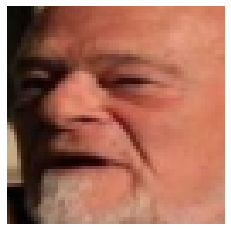

In [ ]:
show_example(*train_ds[30057])

In [ ]:
val_size = len(val_ds)
val_size

11649

Random seed is assigned a specific value so that we recreate the same random split of dataset.

In [ ]:
random_seed = 43
torch.manual_seed(random_seed);

Knowing we would need a test_ds to finally evaluate the model, we are assigning `40%` of validation set to test set. Validation set is also just used to evaluate the model during training so we can afford to split this much amount to test set.

In [ ]:
test_size = int(val_size*0.4)
test_size

4659

In [ ]:
test_ds, val_ds  = random_split(val_ds, [test_size, val_size - test_size ])
test_size = len(test_ds)
val_size = len(val_ds)

We can check the final test and validation set length here 

In [ ]:
len(test_ds)

4659

In [ ]:
len(val_ds)

6990

Lets just confirm the shape of image

In [ ]:
img, label = train_ds[0]
print("Image shape", img.shape)
input_size = img.shape

Image shape torch.Size([3, 64, 64])


It is a 3 channel image with dimension of 64x64 as expected because of transforms applied

## Creating data loaders and moving them to default device

We will now be creating  data loaders of a batch size 64. Now when sometime when we instantiate the model later in the notebook, sometime it gives *Out of Memory* error. In that case we can try reducing the batch size

In [ ]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size,shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

Defining a function to show a batch of data from the data loader

In [ ]:
def show_batch(dl):
  for img, labels in dl:
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    print(img.shape)
    plt.imshow(make_grid(img, nrow=8).permute(1,2,0))
    break


torch.Size([64, 3, 64, 64])


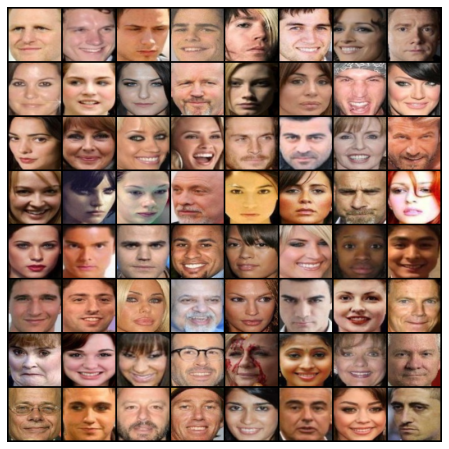

In [ ]:
show_batch(train_loader)

Logging dataset to the notebook hosted on jovian profile( **optional** )

In [ ]:
jovian.log_dataset(train_size = train_size, val_size=val_size, test_size = test_size, random_seed=random_seed, batch_size = batch_size)

[jovian] Dataset logged.


Defining functions to check the available device and then defining a class to wrap our data loaders and move the data to the available device as we require them.

We do this so we can use **GPUs**(Graphing Processing Units) if one is available. We do have access to them in Google Colab and Kaggle

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

Wrapping data loader in `DeviceDataLoader`

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

## Defining the Image Classification base class and extending it to ResNet9 model

We'll define the Image Classification base class which can be used with most Image classification models.
It has utilities to find the losses for training and validation sets and also the accuracy in each epoch

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        labels = labels.to(torch.float32)
        out = out.to(torch.float32)
        loss = F.binary_cross_entropy(out.view(-1), labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        labels = labels.to(torch.float32)
        out = out.to(torch.float32)
        loss = F.binary_cross_entropy(out.view(-1), labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    preds = torch.round(outputs)
    preds = torch.flatten(preds)
    # _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Defining a convolutional block which is used multiple times in the ResNet9 model  

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

Finally lets define the `GenderClassification` model based on the ResNet9 architechure

In [ ]:
class GenderClassification(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.conv1 = conv_block(3, 64)
    self.conv2 = conv_block(64, 128, pool=True) #128x32x32
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
    
    self.conv3 = conv_block(128, 256, pool=True) #256x16x16
    self.conv4 = conv_block(256, 512, pool=True) #512x8x8
    self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
    
    self.classifier = nn.Sequential(nn.MaxPool2d(8), 
                                    nn.Flatten(), 
                                    nn.Dropout(0.2),
                                    nn.Linear(512, 1)
                                   )

  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.classifier(out)
    out = torch.sigmoid(out)
    return out;


In [ ]:
train_ds.classes

['female', 'male']

Here we are instantiating the model and then moving it to the device available

In [ ]:
model = GenderClassification()
model = to_device(model, device)
model

GenderClassification(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Re

Before we start training it is a good idea to empty the cache which releases all unoccupied cached memory currently held by the caching allocator

In [ ]:
torch.cuda.empty_cache()

To make sure everthing is working fine, it is a good idea to first test the model by giving it a single batch of data and check the outputs

In [ ]:
for images, labels in val_loader:
    print('images.shape:', images.shape)
    out = model(images)
    print(labels)
    print('out.shape:', out.shape)
    print(out)
    break


images.shape: torch.Size([128, 3, 64, 64])
tensor([1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
out.shape: torch.Size([128, 1])
tensor([[0.9343],
        [0.8590],
        [0.9004],
        [0.8161],
        [0.9714],
        [0.9222],
        [0.9960],
        [0.8822],
        [0.4826],
        [0.8748],
        [0.8081],
        [0.2886],
        [0.9319],
        [0.8513],
        [0.8105],
        [0.4850],
        [0.8671],
        [0.5845],
        [0.9866],
        [0.6019],
        [0.6677],
        [0.6587],
        [0.7858],
        [0.9007],
        [0.9009],
        [0.5888],
       

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Definition of training and evaluation utility functions
The `get_lr` method is used to get the learning rates during training so that we can keep a track of learning rates as we will be using a learning rate schedular to automatically change the learning rate during training.

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

`evaluate` method evaluates the overall loss and accuracy for the epoch whereas `fit` function contains the actual training loop. We will using certain regularization techniques like gradient clipping and weight decay.

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        train_losses = []
        lrs = []
        model.train()
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            sched.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        result['lrs'] = lrs
        history.append(result)
    return history

Lets just evaluate the randomly initialized model by the val_loader. The accuracy is expeceted to be around `50%` as there are 2 classes and 1 out of 2 guesses can be correct  

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.5061370730400085, 'val_loss': 0.6932529807090759}]

## Training our model
Lets train our model for 5 epochs with a max_lr of 0.01 and a gradient clipping of 0.1 and weight decay of 1e-4 and optimization function of Adam

In [ ]:
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history += fit(epochs, max_lr, model, train_loader, val_loader, weight_decay, grad_clip, opt_func) 

Epoch [0], train_loss: 0.2432, val_loss: 0.2477, val_acc: 0.9009
Epoch [1], train_loss: 0.1915, val_loss: 0.4572, val_acc: 0.8264
Epoch [2], train_loss: 0.1460, val_loss: 0.1223, val_acc: 0.9616
Epoch [3], train_loss: 0.1160, val_loss: 0.1158, val_acc: 0.9615
Epoch [4], train_loss: 0.0841, val_loss: 0.0701, val_acc: 0.9752


We reached a validation accuracy of `97.5%` in just 5 epochs and it seems like we can actually break past 97 in even lesser epochs

In [ ]:
opt_func.__name__

'Adam'

Logging hyperparameters to jovian project on our profile (optional)

In [ ]:
jovian.log_hyperparams({
    'architechure': 'ResNet9',
    'num_epochs': '5',
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': max_lr
})

[jovian] Hyperparams logged.


Defining a helper function to plot accuracies

In [ ]:
def plot_accuracies(history):
  acc = [x['val_acc'] for x in history]
  plt.plot(acc, 'r-')
  plt.xlabel('epochs')
  plt.ylabel('Accuracy')
  plt.title('Accuracies vs no. of Epochs')

As we can see the accuracy starts from about `50%` and finally reaches to around `98%`

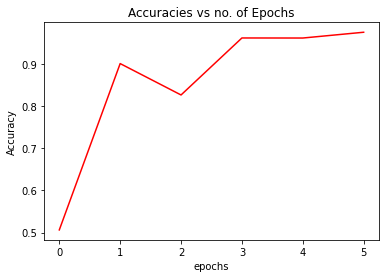

In [ ]:
plot_accuracies(history)

Lets also plot the train and validation losses

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

The losses go down as we proceed as we would expect and one important thing to note is both the losses are going down and it is an indication that the model is not yet overfitting which occurs if the validation loss starts to increase and training loss keeps on decreasing

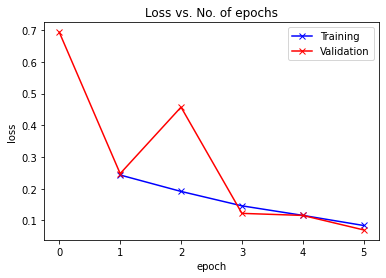

In [ ]:
plot_losses(history)

We can also see the one cycle learning rate schedular in action and check how it varies the learning rate during training.

In [ ]:
import numpy as np
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

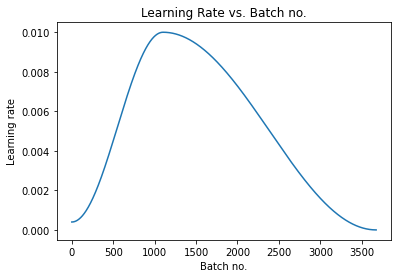

In [ ]:
plot_lrs(history)

## Evaluating model on single images from test set and on custom imported images

It is a good idea to just take outputs from individual outputs. `predict_image` takes in a image and model and then spits out the prediction and probability

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    prob = yb
    yb = (yb>=0.5).int()
    if yb==0:
      prob = 1 - prob
    print("Prediction: ", train_ds.classes[yb]," Probability: ", (prob.item())*100)


First look at a image from the test_ds

Label: female
Prediction:  female  Probability:  99.34298992156982


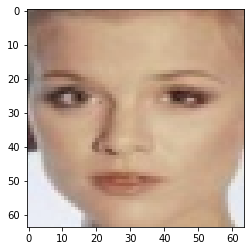

In [ ]:
img, label = test_ds[26]
plt.imshow(img.permute(1,2,0))
print("Label:", train_ds.classes[label] )
predict_image(img, model)


Here we are defining another utility function to predict the images which are not already in the dataset but downloaded from google and then imported into the files.

In [ ]:
from PIL import Image
def predict_mypicture(pic_path):
    pil_img = Image.open(pic_path).convert('RGB')
    imge = val_tfs(pil_img)
    predict_image(imge, model)
    plt.axis('off')
    plt.imshow(imge.permute(1,2,0))

### **Important**

I have created a new folder in the files section of colab and put in some downloaded image. You will have to do the same before you run these `predict_mypicture` functions below. Also, make sure to include the pictures that have only the cropped faces with little or no background because this is the sort of data on which the model was trained. You can see that these images of slight backgrounds and even though the model is predicting them right, the probability is low(model is not that sure)

Prediction:  male  Probability:  60.71082949638367


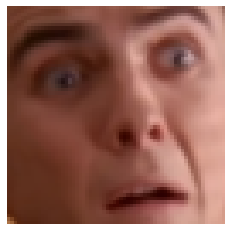

In [ ]:
predict_mypicture('./custom_images/img1.jpg')

Prediction:  male  Probability:  83.94961953163147


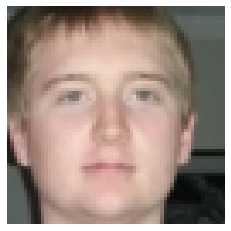

In [ ]:
predict_mypicture('./custom_images/img2.jpg')

Prediction:  female  Probability:  69.89738345146179


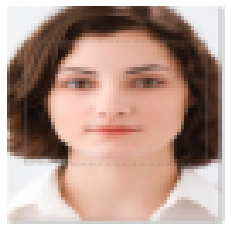

In [ ]:
predict_mypicture('./custom_images/img3.jpg')

Prediction:  female  Probability:  68.23888421058655


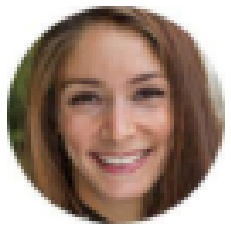

In [ ]:
predict_mypicture('./custom_images/img4.jpg')

Prediction:  female  Probability:  99.67232346534729


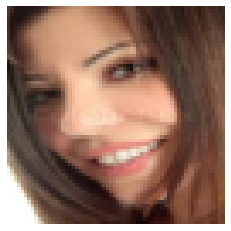

In [ ]:
predict_mypicture('./custom_images/img5.jpg')

Finally this is me :)

Prediction:  male  Probability:  58.609116077423096


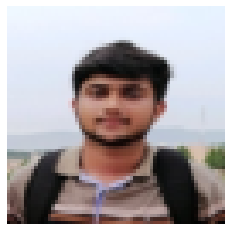

In [ ]:
predict_mypicture('./custom_images/me.jpg')

Creating a test_loader from the test_ds to check the overall accuracy and loss on the test set.

In [ ]:
test_loader = DeviceDataLoader((DataLoader(test_ds, batch_size=2*batch_size)), device)

In [ ]:
test_results = evaluate(model, test_loader)
test_results

{'val_acc': 0.9771959185600281, 'val_loss': 0.061952948570251465}

So `97.71%` is pretty close to the final val_acc 

Lets also save the trained model weights for future use.

In [ ]:
torch.save(model.state_dict(), 'gender-classification-ResNet9-weights.pth')

Logging the final metrics and commiting it to the notebook hosted on jovian

In [ ]:
jovian.log_metrics(test_acc = test_results['val_acc'], test_loss = test_results['val_loss'])

[jovian] Metrics logged.


In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="gender-classification-resnet9", outputs=['gender-classification-ResNet9-weights.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/shehroze-1122/course-final-project


'https://jovian.ai/shehroze-1122/course-final-project'

## Conclusion

In this notebook we created and trained a gender classification model from scratch and reached upto `98%` accuracy on the test set. We used some state of the art techniques about which you can dig deep into here:

1. [Data Augmentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
2. [Transforms](https://pytorch.org/vision/stable/transforms.html)
3. [Convolutional Neural Networks](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)
4. [ResNet9](https://medium.com/swlh/natural-image-classification-using-resnet9-model-6f9dc924cd6d)
5. [Learning Rate Scheduling](https://www.kaggle.com/isbhargav/guide-to-pytorch-learning-rate-scheduling)
6. [Weight Decay](https://medium.com/analytics-vidhya/deep-learning-basics-weight-decay-3c68eb4344e9)
7. [Gradiennt Clipping](https://deepai.org/machine-learning-glossary-and-terms/gradient-clipping)
